In [1]:
import sys
import os
import logging
import ast
import re

import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
pd.set_option('max_rows', 100)
pd.set_option('display.max_colwidth', None)
from scipy import stats
from scipy.special import rel_entr

from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches

In [2]:
def set_style(fsz=14):
    sns.set_context("paper")
    plt.rc('font', family='Linux Libertine')
    sns.set_style("ticks", {"xtick.major.size": 3, "ytick.major.size": 3})
    
    plt.rc('font', size=fsz, family='Linux Libertine')
    plt.rc('axes', titlesize=fsz)
    plt.rc('axes', labelsize=fsz)
    plt.rc('xtick', labelsize=fsz)
    plt.rc('ytick', labelsize=fsz)
    plt.rc('legend', fontsize=fsz)
    plt.rc('figure', titlesize=fsz)
    plt.rcParams["mathtext.fontset"] = "dejavuserif"
    plt.rcParams['hatch.linewidth'] = 2
    
def set_size(fig, width=6, height=4):
    fig.set_size_inches(width, height)
    plt.tight_layout()
    
VIZ_DIR = "/scratchNVM0/ndhuynh/data/figs/"
def save_fig(fig, filename):
    fig.savefig(VIZ_DIR + filename, dpi=300, format='pdf', bbox_inches='tight')

In [3]:
sys.path.insert(1, '/scratchNVM0/ndhuynh/robust-lsm-tuning/endure')
from data.data_provider import DataProvider
from data.data_exporter import DataExporter
from robust.workload_uncertainty import WorkloadUncertainty
from lsm_tree.cost_function import CostFunction
from lsm_tree.nominal import NominalWorkloadTuning

config = DataProvider.read_config('/scratchNVM0/ndhuynh/robust-lsm-tuning/endure/config/robust-lsm-trees.yaml')
de = DataExporter(config)
dp = DataProvider(config)

In [4]:
def process_ios(df, writes=True):
    PAGESIZE = 4096
    if writes:
        nominal_compaction_ios = np.sum((df['nominal_compact_read'] + df['nominal_compact_write']) / PAGESIZE)
        robust_compaction_ios = np.sum((df['robust_compact_read'] + df['robust_compact_write']) / PAGESIZE)
        workload_weight = df['w_s'] / df['w_s'].sum()
        df['nominal_write_io'] = (workload_weight * nominal_compaction_ios) + ((df['nominal_bytes_written'] + df['nominal_flush_written']) / PAGESIZE)
        df['robust_write_io'] = (workload_weight * robust_compaction_ios) + ((df['robust_bytes_written'] + df['robust_flush_written']) / PAGESIZE)
        df['nominal_io'] = df['nominal_blocks_read'] + df['nominal_write_io']
        df['robust_io'] = df['robust_blocks_read'] +  df['robust_write_io']
    else:
        df['nominal_io'] = df['nominal_blocks_read']
        df['robust_io'] = df['robust_blocks_read']
    
    return df

In [25]:
def plot_total_io_diff(df, workload_idx):
    df = df[df.workload_idx == workload_idx]
    z0, z1, q, w = df.z0.iloc[0], df.z1.iloc[0], df.q.iloc[0], df.w.iloc[0]
    df = df.groupby('N').apply(process_ios, writes=False)
    df = df.groupby('N')[['robust_io', 'nominal_io']].sum().reset_index()
    
    fig, ax = plt.subplots()
    
    ax.plot(df['N'], df['robust_io'] / 1e6,  marker='*', color='green', label='Robust')
    ax.plot(df['N'], df['nominal_io']/ 1e6, marker='o', color='black', label='Nominal')
    ax.set_xscale('log')
    ax.set_ylabel('I/Os per Query')
    ax.set_xlabel('Number of Elements in DB (N)')
    ax.set_title(
        'Performance Difference with Database Size (Read Only)' + '\n'
        '$w_{' + str(workload_idx) + '}$ : ' + f'({z0:.0%}, {z1:.0%}, {q:.0%}, {w:.0%})' 
    )
    ax.legend()
    
    return fig, ax

Possible workloads : [ 7 11 16]


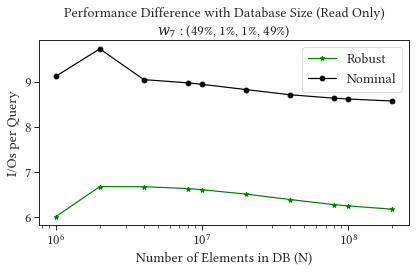

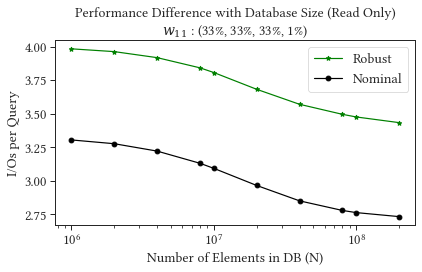

In [44]:
# df = dp.read_csv('experiment_05_checkpoint.csv')
df = dp.read_csv('exp_05_no_writes.csv')
print(f'Possible workloads : {df.workload_idx.unique()}')
wl_idx = 7

set_style()
fig, ax = plot_total_io_diff(df, 7)
set_size(fig)
fig, ax = plot_total_io_diff(df, 11)
set_size(fig)
# fig, ax = plot_total_io_diff(df, 16)
# set_size(fig)

In [38]:
tunings = ['nominal_m_buff', 'nominal_bpe', 
           'nominal_T', 'nominal_is_leveling_policy',
           'nominal_runs_per_level',
           'robust_m_buff', 'robust_bpe',
           'robust_T', 'robust_is_leveling_policy',
           'robust_runs_per_level']
df[df.workload_idx == 7].groupby('N')[tunings].first()

,nominal_m_buff,nominal_bpe,nominal_T,nominal_is_leveling_policy,nominal_runs_per_level,robust_m_buff,robust_bpe,robust_T,robust_is_leveling_policy,robust_runs_per_level
N,,,,,,,,,,
1000000.0,8.388608e+06,10.000000,9.588153,False,"[9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1.304863e+07,5.339973,2.384649,True,"[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2000000.0,9.230400e+06,9.579104,9.414764,False,"[9, 9, 9, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1.904599e+07,4.671310,2.405979,True,"[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4000000.0,1.327618e+07,8.778106,8.864962,False,"[8, 8, 8, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",3.136095e+07,4.256915,2.422631,True,"[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
8000000.0,2.197089e+07,8.302214,8.480516,False,"[8, 8, 8, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",5.620789e+07,4.022589,2.433457,True,"[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
10000000.0,2.638541e+07,8.200319,8.394138,False,"[8, 8, 8, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",6.865661e+07,3.973199,2.435883,True,"[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
20000000.0,4.861919e+07,7.988471,8.204208,False,"[8, 8, 7, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1.309550e+08,3.871682,2.441035,True,"[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
40000000.0,9.323896e+07,7.878741,8.110697,False,"[8, 8, 7, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",2.555915e+08,3.819928,2.444001,True,"[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
80000000.0,1.825900e+08,7.822482,8.050350,False,"[8, 8, 6, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",5.049117e+08,3.793461,2.445415,True,"[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
100000000.0,2.270293e+08,7.813593,8.041415,False,"[8, 8, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",6.295747e+08,3.788139,2.445702,True,"[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [33]:
# df[df.workload_idx == wl_idx].groupby('N')[['nominal_blocks_read', 'robust_blocks_read']].mean()
df.columns

Index(['workload_idx', 'z0', 'z1', 'q', 'w', 'N', 'phi', 'B', 's', 'E', 'M',
       'nominal_m_filt', 'nominal_m_buff', 'nominal_T', 'nominal_cost',
       'nominal_bpe', 'nominal_is_leveling_policy', 'rho', 'robust_exit_mode',
       'robust_m_filt', 'robust_m_buff', 'robust_T', 'robust_cost',
       'robust_is_leveling_policy', 'robust_bpe', 'sample_idx', 'z0_s', 'z1_s',
       'q_s', 'w_s', 'kl_div', 'session_id', 'nominal_l0_hit',
       'nominal_l1_hit', 'nominal_l2_plus_hit', 'nominal_z0_ms',
       'nominal_z1_ms', 'nominal_q_ms', 'nominal_w_ms', 'nominal_filter_neg',
       'nominal_filter_pos', 'nominal_filter_pos_true',
       'nominal_bytes_written', 'nominal_compact_read',
       'nominal_compact_write', 'nominal_flush_written', 'nominal_blocks_read',
       'nominal_runs_per_level', 'robust_l0_hit', 'robust_l1_hit',
       'robust_l2_plus_hit', 'robust_z0_ms', 'robust_z1_ms', 'robust_q_ms',
       'robust_w_ms', 'robust_filter_neg', 'robust_filter_pos',
       'robust_filt

In [9]:
def apply_design(df, cf, z0, z1, q, w, mode='nominal'):
    cf.z0, cf.z1, cf.q, cf.w = z0, z1, q, w
    cost = cf.calculate_cost(df[f'{mode}_m_filt'] / cf.N, np.ceil(df[f'{mode}_T']), df[f'{mode}_is_leveling_policy'])
    return cost

In [10]:
def plot_system(df, ax, num_operations, readonly=False):
    nom_policy = 'Leveling' if df.iloc[0].nominal_is_leveling_policy else 'Tiering'
    robust_policy = 'Leveling' if df.iloc[0].robust_is_leveling_policy else 'Tiering'
    df = process_ios(df, writes=not(readonly)) 
    y1, y2 = df['nominal_io'].values, df['robust_io'].values
    
    w_hat = df[['z0_s', 'z1_s', 'q_s', 'w_s']].mean().values
    w0 = [df['z0'].iloc[0], df['z1'].iloc[0], df['q'].iloc[0], df['w'].iloc[0]]

    ax.text(0.565, 0.9, 'System', fontsize=16, transform=ax.transAxes)
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.plot(df.index.values, y1 / num_operations, marker='*', linewidth=1, color='black',     markersize=8, label=f'Nominal\nh: {(df.iloc[0].nominal_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].nominal_T:.1f}, $\pi$: {nom_policy}')
    ax.plot(df.index.values, y2 / num_operations, marker='o', linewidth=1, color='tab:green', markersize=8, label=f'Robust\nh: {(df.iloc[0].robust_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].robust_T:.1f}, $\pi$: {robust_policy}')
    ax.text(0.84, 0.90, '$w_{' + str(wl_idx) + '}:\ $' + f'({(w0[0] * 100):.0f}%, {(w0[1] * 100):.0f}%, {(w0[2] * 100):.0f}%, {(w0[3] * 100):.0f}%)', transform=ax.transAxes)
    ax.text(0.84, 0.78, '$\hat{w}:\ $' + f'({(w_hat[0] * 100):.0f}%, {(w_hat[1] * 100):.0f}%, {(w_hat[2] * 100):.0f}%, {(w_hat[3] * 100):.0f}%)', transform=ax.transAxes)
    ax.legend(loc='upper left', bbox_to_anchor=(0, 1), frameon=True, framealpha=1, edgecolor='black', fancybox=False, ncol=2)
    
    return df, ax
    
def plot_model(df, ax):
    w_hat = df[['z0_s', 'z1_s', 'q_s', 'w_s']].mean().values
    w0 = [df['z0'].iloc[0], df['z1'].iloc[0], df['q'].iloc[0], df['w'].iloc[0]]
    distance = np.sum(rel_entr(w_hat, w0))
    
    cfg = config['lsm_tree_config'].copy()
    cfg['N'], cfg['M'] = df.iloc[0].N, df.iloc[0].M
    cf = CostFunction(**cfg, z0=w_hat[0], z1=w_hat[1], q=w_hat[2], w=w_hat[3])
    df['nominal_cost'] = df.apply(lambda row: apply_design(row, cf, row['z0_s'], row['z1_s'], row['q_s'], row['w_s'], 'nominal'), axis=1)
    df['robust_cost'] = df.apply(lambda row: apply_design(row, cf, row['z0_s'], row['z1_s'], row['q_s'], row['w_s'], 'robust'), axis=1)

    nom_policy = 'Leveling' if df.iloc[0].nominal_is_leveling_policy else 'Tiering'
    robust_policy = 'Leveling' if df.iloc[0].robust_is_leveling_policy else 'Tiering'
    y1, y2 = df.nominal_cost, df.robust_cost
    
    ax.text(0.565, 0.9, 'Model', fontsize=16, transform=ax.transAxes)
    ax.plot(df.index.values, y1, marker='*', linewidth=1, color='black',     markersize=8, label=f'Nominal\nh: {(df.iloc[0].nominal_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].nominal_T:.1f}, $\pi$: {nom_policy}')
    ax.plot(df.index.values, y2, marker='o', linewidth=1, color='tab:green', markersize=8, label=f'Robust\nh: {(df.iloc[0].robust_m_filt / df.iloc[0].N):.1f}, T: {df.iloc[0].robust_T:.1f}, $\pi$: {robust_policy}')
    
    return df, ax

In [11]:
def plot_cost_sessions(df, samples, num_operations, wl_idx, robust_rho, readonly=False):
    num_sessions = df.shape[0] / samples
    means = []
    for idx in range(0, df.shape[0], samples):
        means.append(df.iloc[idx:idx+samples][['z0_s', 'z1_s', 'q_s', 'w_s']].mean())
        
    w_hat = df[['z0_s', 'z1_s', 'q_s', 'w_s']].mean().values
    w0 = [df['z0'].iloc[0], df['z1'].iloc[0], df['q'].iloc[0], df['w'].iloc[0]]
    distance = np.sum(rel_entr(w_hat, w0))

    fig, axes = plt.subplots(ncols=1, nrows=2)
    system_ax, model_ax = axes
    for ax in axes:
        ax.set_xlim(left=-0.25, right=(num_sessions * samples) - 0.75)
        for bounds in np.arange(samples - 1, num_sessions * samples - 1, samples):
            ax.axvline(x=bounds + 0.5, linestyle='--', linewidth=4, color='tab:gray', alpha=0.5)
            
    # Graphs
    df, system_ax = plot_system(df, system_ax, num_operations, readonly=readonly)
    df, model_ax = plot_model(df, model_ax)
    
    # Labels
    model_ax.set_xticks([(samples)/2 - 0.25] + [x + 0.5 for x in np.arange((samples/2) + samples - 1, num_sessions * samples - 1, samples)])
    model_ax.text(0.025, -0.22, f'({(means[0].z0_s * 100):.0f}%, {(means[0].z1_s * 100):.0f}%, {(means[0].q_s * 100):.0f}%, {(means[0].w_s * 100):.0f}%)', alpha=1, transform=model_ax.transAxes)
    model_ax.text(0.200, -0.22, f'({(means[1].z0_s * 100):.0f}%, {(means[1].z1_s * 100):.0f}%, {(means[1].q_s * 100):.0f}%, {(means[1].w_s * 100):.0f}%)', alpha=1, transform=model_ax.transAxes)
    model_ax.text(0.360, -0.22, f'({(means[2].z0_s * 100):.0f}%, {(means[2].z1_s * 100):.0f}%, {(means[2].q_s * 100):.0f}%, {(means[2].w_s * 100):.0f}%)', alpha=1, transform=model_ax.transAxes)
    model_ax.text(0.535, -0.22, f'({(means[3].z0_s * 100):.0f}%, {(means[3].z1_s * 100):.0f}%, {(means[3].q_s * 100):.0f}%, {(means[3].w_s * 100):.0f}%)', alpha=1, transform=model_ax.transAxes)
    model_ax.text(0.700, -0.22, f'({(means[4].z0_s * 100):.0f}%, {(means[4].z1_s * 100):.0f}%, {(means[4].q_s * 100):.0f}%, {(means[4].w_s * 100):.0f}%)', alpha=1, transform=model_ax.transAxes)
    model_ax.text(0.870, -0.22, f'({(means[5].z0_s * 100):.0f}%, {(means[5].z1_s * 100):.0f}%, {(means[5].q_s * 100):.0f}%, {(means[5].w_s * 100):.0f}%)', alpha=1, transform=model_ax.transAxes)

    if readonly:
        model_ax.set_xticklabels(['1. Expected', '2. Reads', '3. Range', '4. Empty Reads', '5. Reads', '6. Reads'])
    else:
        model_ax.set_xticklabels(['1. Reads', '2. Range', '3. Empty Reads', '4. Non-Empty Reads', '5. Writes', '6. Expected'])
    
    fig.supylabel('Average I/Os per Query')
    model_ax.text(0.885, 0.75, '$I_{KL}(\hat{w}, w) :$' + f'{distance:.2f}', transform=model_ax.transAxes)
    model_ax.text(0.945, 0.88, r'$\rho :$' + f'{robust_rho:.2f}', transform=model_ax.transAxes)
    
    return fig, axes

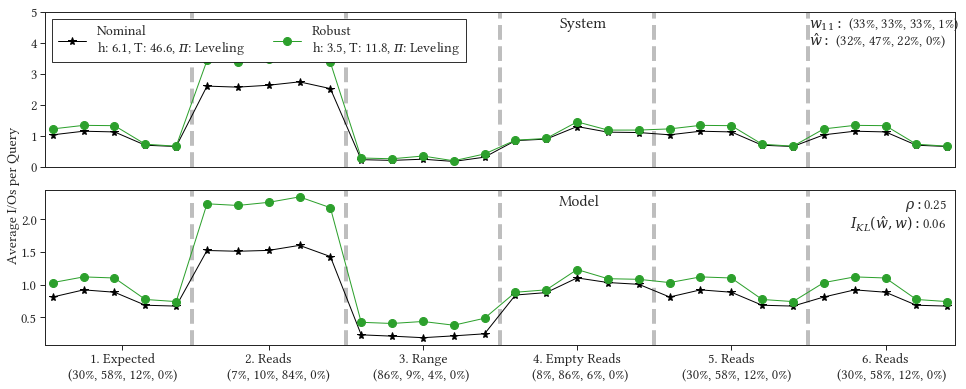

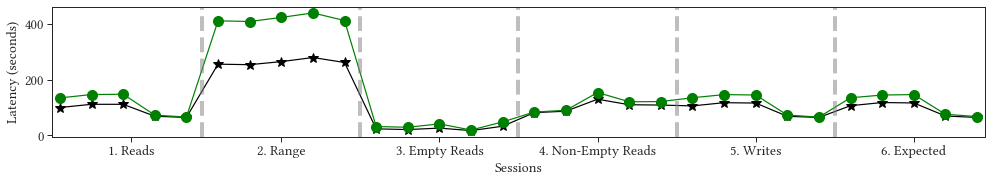

In [43]:
df = dp.read_csv('experiment_05_checkpoint.csv')
df['nominal_ms'] = df['nominal_z0_ms'] + df['nominal_z1_ms'] + df['nominal_q_ms'] + df['nominal_w_ms']
df['robust_ms'] = df['robust_z0_ms'] + df['robust_z1_ms'] + df['robust_q_ms'] + df['robust_w_ms']

N, wl_idx = 1e6, 11
d = df[(df.workload_idx == wl_idx) & (df.N == N)].reset_index()
fig, axes = plot_cost_sessions(d, 5, 100000, wl_idx, df.rho.iloc[0], readonly=True)
axes[0].set_ylim([0, 5])
# axes[1].set_ylim([0, 160])
set_size(fig, width=2*7, height=2*2.75)

fig, ax = plt.subplots()
ax.plot(d.index.values, d['nominal_ms'] / 100, '-*', markersize=10, color='black')
ax.plot(d.index.values, d['robust_ms']  / 100, '-o', markersize=10, color='green')

bounds = [5, 10, 15, 20, 25]
ax.set_xlim(left=-0.25, right=29.25)
for bound in bounds:
    ax.axvline(x=bound - 0.5, linestyle='--', linewidth=4, color='tab:gray', alpha=0.5)

ax.set_xticks([4.5 / 2, (4.5 + 9.5) / 2, (9.5 + 14.5) / 2, (14.5 + 19.5) / 2, (19.5 + 24.5) / 2, (24.5 + 29.5) / 2])
ax.set_xticklabels(['1. Reads', '2. Range', '3. Empty Reads', '4. Non-Empty Reads', '5. Writes', '6. Expected'])

ax.set_ylabel('Latency (seconds)')
ax.set_xlabel('Sessions')
set_size(fig, width=14, height=2.75)